<a href="https://colab.research.google.com/github/Zachary-Wenhao/IML-Team-Attack-Diffusion-Model/blob/diffusion/diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
diffusion_path = '/content/drive/My Drive/IML Final Project/diffusion/'
print(os.listdir(diffusion_path))

['256x256_diffusion.pt']


# Dependency

In [28]:
# uncomment to install the necessary libraries in Colab
!pip install diffusers transformers accelerate torch torchvision --quiet

Load model from pre-trained repo

In [29]:
# Import libraries
import os
import pickle
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
from torch.utils.data import DataLoader, Dataset
from google.colab import files
from google.colab import drive
from torchvision import transforms

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [30]:
def tensor_to_pil_image(tensor):
  # Undo normalization
  unnormalize = transforms.Normalize(
      mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
      std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
  )
  tensor = unnormalize(tensor)  # Undo normalization
  tensor = tensor.clip(0, 1)  # Clip values to [0, 1] for valid image range
  tensor = tensor.permute(1, 2, 0)  # Rearrange dimensions to (H, W, C)
  return Image.fromarray((tensor.numpy() * 255).astype('uint8'))  # Convert to PIL

# Attack data loading

In [31]:
drive.mount('/content/drive')
path_data = '/content/drive/My Drive/IML Final Project/diffusion/'
def load_pkl(file_path):
  with open(file_path, 'rb') as f:
    data = pickle.load(f)
  return data

Mounted at /content/drive


In [32]:
# Load datasets
train_attack_dataset = load_pkl(os.path.join(path_data, 'train_attack_dataset.pkl'))
train_swap_attack_dataset = load_pkl(os.path.join(path_data, 'train_swap_attack_dataset.pkl'))
val_attack_dataset = load_pkl(os.path.join(path_data, 'val_attack_dataset.pkl'))
val_swap_attack_dataset = load_pkl(os.path.join(path_data, 'val_swap_attack_dataset.pkl'))

In [33]:
# Sample Inspection
print(next(iter(train_attack_dataset))[0].shape)
print(next(iter(train_swap_attack_dataset))[0].shape)
print(next(iter(val_attack_dataset))[0].shape)
print(next(iter(val_swap_attack_dataset))[0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
pipeline = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True)
pipeline.to(device)

device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [36]:
attacked_img =  next(iter(train_attack_dataset))[0]
attacked_img


tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  0.3652,  0.0569,  0.0569],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.3652, -1.2788,  0.0569],
         [ 2.2489,  1.3070,  2.2489,  ...,  0.3481,  0.0398,  0.0398],
         ...,
         [-0.2513, -0.2513, -0.5596,  ..., -0.8164, -0.8335, -0.8335],
         [-0.3369, -0.5596, -0.3198,  ..., -1.5528, -0.8849, -0.8849],
         [-0.3369, -0.5596, -0.5596,  ..., -0.8678, -0.8849, -0.8849]],

        [[ 0.3452,  0.3452,  0.3452,  ...,  1.1155,  0.8179,  0.8179],
         [ 0.3452,  0.3452,  0.3452,  ...,  1.1155, -1.1779,  0.8179],
         [ 0.3102,  1.4832,  0.3102,  ...,  1.0980,  0.8004,  0.8004],
         ...,
         [-0.1275, -0.1275,  0.0476,  ..., -0.8978, -0.9153, -0.9153],
         [-0.2150,  0.0476, -0.1975,  ..., -1.5805, -0.9678, -0.9678],
         [-0.2150,  0.0476,  0.0476,  ..., -0.9503, -0.9678, -0.9678]],

        [[ 1.5594,  1.5594,  1.5594,  ...,  1.2980,  1.0017,  1.0017],
         [ 1.5594,  1.5594,  1.5594,  ...,  1

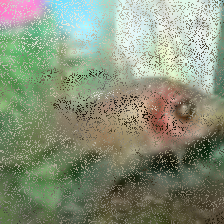

In [39]:
display(tensor_to_pil_image(attacked_img))

In [40]:
image = pipeline(prompt="", image=attacked_img)
image

  0%|          | 0/50 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x791195023E80>], nsfw_content_detected=[False])

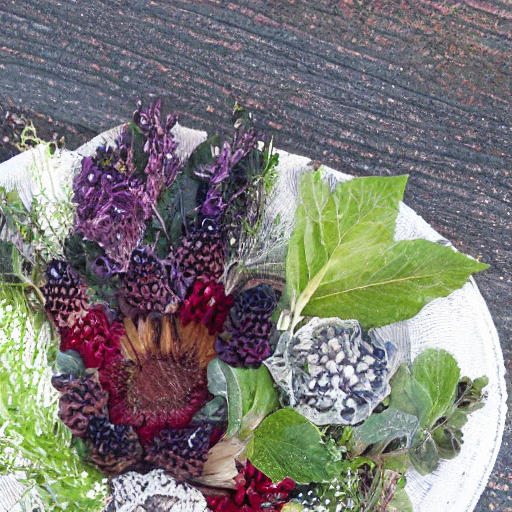

In [41]:
image.images[0]

In [42]:

vae = pipeline.vae

# Ensure the image is normalized to [-1, 1]
attacked_img = attacked_img / 127.5 - 1.0

# Add a batch dimension and move to GPU
attacked_img = attacked_img.unsqueeze(0).to("cuda")

# Encode the noisy image into latents
latents = vae.encode(attacked_img).latent_dist.sample()

# Scale the latents as expected by the pipeline
latents = latents * 0.18215

# Use the latents as the starting point for denoising
output = pipeline(prompt="", latents=latents)

# Get the purified image
purified_image = output.images[0]

# Display the purified image
purified_image.show()

  0%|          | 0/50 [00:00<?, ?it/s]

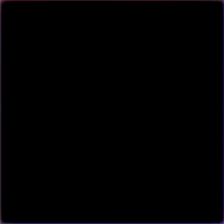

In [43]:
purified_image

In [46]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the pipeline
pipeline = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
vae = pipeline.vae

# Assume `attacked_img` is your noisy image tensor in [0, 255] range
attacked_img = attacked_img / 127.5 - 1.0  # Normalize to [-1, 1]
attacked_img = attacked_img.unsqueeze(0).to("cuda")  # Add batch dimension and move to GPU

# Encode the noisy image into latents
latents = vae.encode(attacked_img).latent_dist.sample()
latents = latents * 0.18215  # Scale the latents as expected by the pipeline

# Decode latents for debugging
decoded_img = vae.decode(latents / 0.18215).sample
decoded_img = (decoded_img.clamp(-1, 1) + 1) / 2  # Map to [0, 1]
decoded_img = decoded_img.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(decoded_img)
plt.title("Decoded Image from Latents")
plt.show()

# Run purification with pipeline
output = pipeline(prompt="", latents=latents, num_inference_steps=50)
purified_image = output.images[0]

# Display the purified image
purified_image.show()


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

In [ ]:
# Create a directory to save purified images
purified_dir = "purified_images"
os.makedirs(purified_dir, exist_ok=True)
purified_images = []
purified_images.append(image.images[0])

# Save each purified image
img_filename = f"purified_image_{len(purified_images)}.png"
image.images[0].save(os.path.join(purified_dir, img_filename))

# Guided Diffusion

In [ ]:
diffusion_path = '/content/drive/My Drive/IML Final Project/diffusion/'
print(os.listdir(diffusion_path))

['256x256_diffusion.pt', 'val_swap_attack_dataset.pkl', 'train_swap_attack_dataset.pkl', 'train_attack_dataset.pkl', 'val_attack_dataset.pkl', 'Test.ipynb']


In [ ]:
import torch.nn as nn

class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        # Define layers here based on the original architecture
        # Example:
        self.layer1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.layer2 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Instantiate the model
diffusion_model = DiffusionModel()

model_path = os.path.join(diffusion_path, '256x256_diffusion.pt')
state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
diffusion_model.load_state_dict(state_dict)
diffusion_model = diffusion_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
diffusion_model.eval()
print("Model loaded and ready for inference.")

<ipython-input-43-9f5b9c73ac71>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_avail

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.06 GiB. GPU 0 has a total capacity of 14.75 GiB of which 81.06 MiB is free. Process 4886 has 14.67 GiB memory in use. Of the allocated memory 14.39 GiB is allocated by PyTorch, and 153.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Load the diffusion model
def load_diffusion_model(model_path):
    model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return model

In [ ]:
# Load the diffusion model
model_path = os.path.join(diffusion_path, '256x256_diffusion.pt')
diffusion_model = load_diffusion_model(model_path)
print("Model loaded successfully.")

<ipython-input-37-f5729c64af93>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available()

Model loaded successfully.


In [ ]:
# Process images using the diffusion model
def denoise_image(model, image_tensor):
    with torch.no_grad():
        denoised_image = model(image_tensor)
    return denoised_image
processed_images = [next(iter(train_attack_dataset))[0]]
# Create a directory to save purified images
purified_dir = "purified_images"
os.makedirs(purified_dir, exist_ok=True)

# Batch process images
for idx, img in enumerate(processed_images):

    # Denoise the image
    denoised_image_tensor = denoise_image(diffusion_model, img)

    # Convert tensor back to PIL image
    denoised_image = ToPILImage()(denoised_image_tensor.squeeze(0).cpu())

    # Save the purified image
    img_filename = f"purified_image_{idx + 1}.png"
    denoised_image.save(os.path.join(purified_dir, img_filename))

TypeError: 'collections.OrderedDict' object is not callable

In [ ]:
# ---------------------------------------------------------------
# Copyright (c) 2022, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the NVIDIA Source Code License
# for DiffPure. To view a copy of this license, see the LICENSE file.
# ---------------------------------------------------------------

import argparse
import logging
import yaml
import os
import time

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from autoattack import AutoAttack
from stadv_eot.attacks import StAdvAttack

import utils
from utils import str2bool, get_accuracy, get_image_classifier, load_data

from runners.diffpure_ddpm import Diffusion
from runners.diffpure_guided import GuidedDiffusion
from runners.diffpure_sde import RevGuidedDiffusion
from runners.diffpure_ode import OdeGuidedDiffusion
from runners.diffpure_ldsde import LDGuidedDiffusion


class SDE_Adv_Model(nn.Module):
    def __init__(self, args, config):
        super().__init__()
        self.args = args

        # image classifier
        self.classifier = get_image_classifier(args.classifier_name).to(config.device)

        # diffusion model
        print(f'diffusion_type: {args.diffusion_type}')
        if args.diffusion_type == 'ddpm':
            self.runner = GuidedDiffusion(args, config, device=config.device)
        elif args.diffusion_type == 'sde':
            self.runner = RevGuidedDiffusion(args, config, device=config.device)
        elif args.diffusion_type == 'ode':
            self.runner = OdeGuidedDiffusion(args, config, device=config.device)
        elif args.diffusion_type == 'ldsde':
            self.runner = LDGuidedDiffusion(args, config, device=config.device)
        elif args.diffusion_type == 'celebahq-ddpm':
            self.runner = Diffusion(args, config, device=config.device)
        else:
            raise NotImplementedError('unknown diffusion type')

        # use `counter` to record the the sampling time every 5 NFEs (note we hardcoded print freq to 5,
        # and you may want to change the freq)
        self.register_buffer('counter', torch.zeros(1, device=config.device))
        self.tag = None

    def reset_counter(self):
        self.counter = torch.zeros(1, dtype=torch.int, device=config.device)

    def set_tag(self, tag=None):
        self.tag = tag

    def forward(self, x):
        counter = self.counter.item()
        if counter % 5 == 0:
            print(f'diffusion times: {counter}')

        # imagenet [3, 224, 224] -> [3, 256, 256] -> [3, 224, 224]
        if 'imagenet' in self.args.domain:
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        start_time = time.time()
        x_re = self.runner.image_editing_sample((x - 0.5) * 2, bs_id=counter, tag=self.tag)
        minutes, seconds = divmod(time.time() - start_time, 60)

        if 'imagenet' in self.args.domain:
            x_re = F.interpolate(x_re, size=(224, 224), mode='bilinear', align_corners=False)

        if counter % 5 == 0:
            print(f'x shape (before diffusion models): {x.shape}')
            print(f'x shape (before classifier): {x_re.shape}')
            print("Sampling time per batch: {:0>2}:{:05.2f}".format(int(minutes), seconds))

        out = self.classifier((x_re + 1) * 0.5)

        self.counter += 1

        return out


def eval_autoattack(args, config, model, x_val, y_val, adv_batch_size, log_dir):
    ngpus = torch.cuda.device_count()
    model_ = model
    if ngpus > 1:
        model_ = model.module

    attack_version = args.attack_version  # ['standard', 'rand', 'custom']
    if attack_version == 'standard':
        attack_list = ['apgd-ce', 'apgd-t', 'fab-t', 'square']
    elif attack_version == 'rand':
        attack_list = ['apgd-ce', 'apgd-dlr']
    elif attack_version == 'custom':
        attack_list = args.attack_type.split(',')
    else:
        raise NotImplementedError(f'Unknown attack version: {attack_version}!')
    print(f'attack_version: {attack_version}, attack_list: {attack_list}')  # ['apgd-ce', 'apgd-t', 'fab-t', 'square']

    # ---------------- apply the attack to classifier ----------------
    print(f'apply the attack to classifier [{args.lp_norm}]...')
    classifier = get_image_classifier(args.classifier_name).to(config.device)
    adversary_resnet = AutoAttack(classifier, norm=args.lp_norm, eps=args.adv_eps,
                                  version=attack_version, attacks_to_run=attack_list,
                                  log_path=f'{log_dir}/log_resnet.txt', device=config.device)
    if attack_version == 'custom':
        adversary_resnet.apgd.n_restarts = 1
        adversary_resnet.fab.n_restarts = 1
        adversary_resnet.apgd_targeted.n_restarts = 1
        adversary_resnet.fab.n_target_classes = 9
        adversary_resnet.apgd_targeted.n_target_classes = 9
        adversary_resnet.square.n_queries = 5000
    if attack_version == 'rand':
        adversary_resnet.apgd.eot_iter = args.eot_iter
        print(f'[classifier] rand version with eot_iter: {adversary_resnet.apgd.eot_iter}')
    print(f'{args.lp_norm}, epsilon: {args.adv_eps}')

    x_adv_resnet = adversary_resnet.run_standard_evaluation(x_val, y_val, bs=adv_batch_size)
    print(f'x_adv_resnet shape: {x_adv_resnet.shape}')
    torch.save([x_adv_resnet, y_val], f'{log_dir}/x_adv_resnet_sd{args.seed}.pt')

    # ---------------- apply the attack to sde_adv ----------------
    print(f'apply the attack to sde_adv [{args.lp_norm}]...')
    model_.reset_counter()
    adversary_sde = AutoAttack(model, norm=args.lp_norm, eps=args.adv_eps,
                               version=attack_version, attacks_to_run=attack_list,
                               log_path=f'{log_dir}/log_sde_adv.txt', device=config.device)
    if attack_version == 'custom':
        adversary_sde.apgd.n_restarts = 1
        adversary_sde.fab.n_restarts = 1
        adversary_sde.apgd_targeted.n_restarts = 1
        adversary_sde.fab.n_target_classes = 9
        adversary_sde.apgd_targeted.n_target_classes = 9
        adversary_sde.square.n_queries = 5000
    if attack_version == 'rand':
        adversary_sde.apgd.eot_iter = args.eot_iter
        print(f'[adv_sde] rand version with eot_iter: {adversary_sde.apgd.eot_iter}')
    print(f'{args.lp_norm}, epsilon: {args.adv_eps}')

    x_adv_sde = adversary_sde.run_standard_evaluation(x_val, y_val, bs=adv_batch_size)
    print(f'x_adv_sde shape: {x_adv_sde.shape}')
    torch.save([x_adv_sde, y_val], f'{log_dir}/x_adv_sde_sd{args.seed}.pt')


def eval_stadv(args, config, model, x_val, y_val, adv_batch_size, log_dir):
    ngpus = torch.cuda.device_count()
    model_ = model
    if ngpus > 1:
        model_ = model.module

    x_val, y_val = x_val.to(config.device), y_val.to(config.device)
    print(f'bound: {args.adv_eps}')

    # apply the attack to resnet
    print(f'apply the stadv attack to resnet...')
    resnet = get_image_classifier(args.classifier_name).to(config.device)

    start_time = time.time()
    init_acc = get_accuracy(resnet, x_val, y_val, bs=adv_batch_size)
    print('initial accuracy: {:.2%}, time elapsed: {:.2f}s'.format(init_acc, time.time() - start_time))

    adversary_resnet = StAdvAttack(resnet, bound=args.adv_eps, num_iterations=100, eot_iter=args.eot_iter)

    start_time = time.time()
    x_adv_resnet = adversary_resnet(x_val, y_val)

    robust_acc = get_accuracy(resnet, x_adv_resnet, y_val, bs=adv_batch_size)
    print('robust accuracy: {:.2%}, time elapsed: {:.2f}s'.format(robust_acc, time.time() - start_time))

    print(f'x_adv_resnet shape: {x_adv_resnet.shape}')
    torch.save([x_adv_resnet, y_val], f'{log_dir}/x_adv_resnet_sd{args.seed}.pt')

    # apply the attack to sde_adv
    print(f'apply the stadv attack to sde_adv...')

    start_time = time.time()
    model_.reset_counter()
    model_.set_tag('no_adv')
    init_acc = get_accuracy(model, x_val, y_val, bs=adv_batch_size)
    print('initial accuracy: {:.2%}, time elapsed: {:.2f}s'.format(init_acc, time.time() - start_time))

    adversary_sde = StAdvAttack(model, bound=args.adv_eps, num_iterations=100, eot_iter=args.eot_iter)

    start_time = time.time()
    model_.reset_counter()
    model_.set_tag()
    x_adv_sde = adversary_sde(x_val, y_val)

    model_.reset_counter()
    model_.set_tag('sde_adv')
    robust_acc = get_accuracy(model, x_adv_sde, y_val, bs=adv_batch_size)
    print('robust accuracy: {:.2%}, time elapsed: {:.2f}s'.format(robust_acc, time.time() - start_time))

    print(f'x_adv_sde shape: {x_adv_sde.shape}')
    torch.save([x_adv_sde, y_val], f'{log_dir}/x_adv_sde_sd{args.seed}.pt')


def robustness_eval(args, config):
    middle_name = '_'.join([args.diffusion_type, args.attack_version]) if args.attack_version in ['stadv', 'standard', 'rand'] \
        else '_'.join([args.diffusion_type, args.attack_version, args.attack_type])
    log_dir = os.path.join(args.image_folder, args.classifier_name, middle_name,
                           'seed' + str(args.seed), 'data' + str(args.data_seed))
    os.makedirs(log_dir, exist_ok=True)
    args.log_dir = log_dir
    logger = utils.Logger(file_name=f'{log_dir}/log.txt', file_mode="w+", should_flush=True)

    ngpus = torch.cuda.device_count()
    adv_batch_size = args.adv_batch_size * ngpus
    print(f'ngpus: {ngpus}, adv_batch_size: {adv_batch_size}')

    # load model
    print('starting the model and loader...')
    model = SDE_Adv_Model(args, config)
    if ngpus > 1:
        model = torch.nn.DataParallel(model)
    model = model.eval().to(config.device)

    # load data
    x_val, y_val = load_data(args, adv_batch_size)

    # eval classifier and sde_adv against attacks
    if args.attack_version in ['standard', 'rand', 'custom']:
        eval_autoattack(args, config, model, x_val, y_val, adv_batch_size, log_dir)
    elif args.attack_version == 'stadv':
        eval_stadv(args, config, model, x_val, y_val, adv_batch_size, log_dir)
    else:
        raise NotImplementedError(f'unknown attack_version: {args.attack_version}')

    logger.close()


def parse_args_and_config():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])
    # diffusion models
    parser.add_argument('--config', type=str, required=True, help='Path to the config file')
    parser.add_argument('--data_seed', type=int, default=0, help='Random seed')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--exp', type=str, default='exp', help='Path for saving running related data.')
    parser.add_argument('--verbose', type=str, default='info', help='Verbose level: info | debug | warning | critical')
    parser.add_argument('-i', '--image_folder', type=str, default='images', help="The folder name of samples")
    parser.add_argument('--ni', action='store_true', help="No interaction. Suitable for Slurm Job launcher")
    parser.add_argument('--sample_step', type=int, default=1, help='Total sampling steps')
    parser.add_argument('--t', type=int, default=400, help='Sampling noise scale')
    parser.add_argument('--t_delta', type=int, default=15, help='Perturbation range of sampling noise scale')
    parser.add_argument('--rand_t', type=str2bool, default=False, help='Decide if randomize sampling noise scale')
    parser.add_argument('--diffusion_type', type=str, default='ddpm', help='[ddpm, sde]')
    parser.add_argument('--score_type', type=str, default='guided_diffusion', help='[guided_diffusion, score_sde]')
    parser.add_argument('--eot_iter', type=int, default=20, help='only for rand version of autoattack')
    parser.add_argument('--use_bm', action='store_true', help='whether to use brownian motion')

    # LDSDE
    parser.add_argument('--sigma2', type=float, default=1e-3, help='LDSDE sigma2')
    parser.add_argument('--lambda_ld', type=float, default=1e-2, help='lambda_ld')
    parser.add_argument('--eta', type=float, default=5., help='LDSDE eta')
    parser.add_argument('--step_size', type=float, default=1e-3, help='step size for ODE Euler method')

    # adv
    parser.add_argument('--domain', type=str, default='celebahq', help='which domain: celebahq, cat, car, imagenet')
    parser.add_argument('--classifier_name', type=str, default='Eyeglasses', help='which classifier to use')
    parser.add_argument('--partition', type=str, default='val')
    parser.add_argument('--adv_batch_size', type=int, default=64)
    parser.add_argument('--attack_type', type=str, default='square')
    parser.add_argument('--lp_norm', type=str, default='Linf', choices=['Linf', 'L2'])
    parser.add_argument('--attack_version', type=str, default='custom')

    parser.add_argument('--num_sub', type=int, default=1000, help='imagenet subset')
    parser.add_argument('--adv_eps', type=float, default=0.07)

    args = parser.parse_args()

    # parse config file
    with open(os.path.join('configs', args.config), 'r') as f:
        config = yaml.safe_load(f)
    new_config = utils.dict2namespace(config)

    level = getattr(logging, args.verbose.upper(), None)
    if not isinstance(level, int):
        raise ValueError('level {} not supported'.format(args.verbose))

    handler1 = logging.StreamHandler()
    formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
    handler1.setFormatter(formatter)
    logger = logging.getLogger()
    logger.addHandler(handler1)
    logger.setLevel(level)

    args.image_folder = os.path.join(args.exp, args.image_folder)
    os.makedirs(args.image_folder, exist_ok=True)

    # add device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    logging.info("Using device: {}".format(device))
    new_config.device = device

    # set random seed
    torch.manual_seed(args.seed)
    random.seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    torch.backends.cudnn.benchmark = True

    return args, new_config


if __name__ == '__main__':
    args, config = parse_args_and_config()
    # os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_ids
    robustness_eval(args, config)

In [13]:
!apt-get update && apt-get install -y --no-install-recommends \
    build-essential \
    autoconf \
    automake \
    libtool \
    pkg-config \
    ca-certificates \
    wget \
    git \
    curl \
    libjpeg-dev \
    libpng-dev \
    python3 \
    python3-dev \
    python3-pip \
    python3-setuptools \
    zlib1g-dev \
    swig \
    cmake \
    vim \
    locales \
    locales-all \
    screen \
    zip \
    unzip


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [14]:
!locale-gen en_US.UTF-8
!update-locale LANG=en_US.UTF-8

Generating locales (this might take a while)...
  en_US.UTF-8... done
Generation complete.


In [15]:
import os
os.environ["LC_ALL"] = "en_US.UTF-8"
os.environ["LANG"] = "en_US.UTF-8"
os.environ["LANGUAGE"] = "en_US.UTF-8"

In [10]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [16]:
!ln -s /usr/bin/python3 /usr/local/bin/python
!ln -s /usr/bin/pip3 /usr/local/bin/pip

ln: failed to create symbolic link '/usr/local/bin/python': File exists
ln: failed to create symbolic link '/usr/local/bin/pip': File exists


In [17]:
!pip install --upgrade pip setuptools



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Uninstalling setuptools-75.1.0:
      Successfully uninstalled setuptools-75.1.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [22]:
!pip install --upgrade pip setuptools wheel


In [24]:
!pip install virtualenv
!virtualenv myenv
!source myenv/bin/activate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 98.9 MB/s eta 0:00:00
created virtual environment CPython3.10.12.final.0-64 in 875ms
  creator CPython3Posix(dest=/content/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.3.1, setuptools==75.6.0, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [27]:
!pip install numpy>=1.20.0 \
                scipy==1.5.2 \
                torch==1.7.1 \
                torchvision==0.8.2 \
                pillow==7.2.0 \
                matplotlib==3.3.0 \
                tqdm==4.56.1 \
                tensorboardX==2.0 \
                seaborn==0.10.1 \
                pandas==1.2.0 \
                requests==2.25.0 \
                xvfbwrapper==0.2.9 \
                torchdiffeq==0.2.1 \
                timm==0.5.4 \
                lmdb \
                Ninja \
                foolbox \
                torchsde \
                git+https://github.com/RobustBench/robustbench.git


  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-bcg1w_n9
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [12]:
! docker build -f diffpure.Dockerfile --tag=diffpure:0.0.1 .

/bin/bash: line 1: docker: command not found
